In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%matplotlib inline

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, log_loss, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

## Connecting to the PostgreSQL database

In [2]:
# Postgres info to connect

connection_args = {
    'host': 'MY CURRENT AWS IP ADDRESS',  # My current AWS IP Address
    'dbname': 'voting',    # DB that we are connecting to
    'port': 5432,          # port on AWS
    'user': 'ubuntu'       #username
}


connection = pg.connect(**connection_args)

In [3]:
query = "SELECT * FROM bye;"

pd_sql.read_sql(query, connection)

,user_id,yob,gender,income,householdstatus,educationlevel,party,q124742,q124122,q123464,...,q100010,q99716,q99581,q99480,q98869,q98578,q98059,q98078,q98197,q96024
0,1,1938,Male,None,Married (w/kids),None,Democrat,No,None,No,...,Yes,No,No,None,No,None,Only-child,No,No,Yes
1,4,1970,Female,"over $150,000",Domestic Partners (w/kids),Bachelor's Degree,Democrat,None,Yes,No,...,None,None,None,No,No,No,Only-child,Yes,No,No
2,5,1997,Male,"$75,000 - $100,000",Single (no kids),High School Diploma,Republican,None,Yes,Yes,...,Yes,No,No,No,Yes,No,Yes,No,Yes,No
3,8,1983,Male,"$100,001 - $150,000",Married (w/kids),Bachelor's Degree,Democrat,No,Yes,No,...,No,No,No,Yes,Yes,No,Yes,No,No,Yes
4,9,1984,Female,"$50,000 - $74,999",Married (w/kids),High School Diploma,Republican,No,Yes,No,...,Yes,No,No,Yes,No,No,Yes,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,6952,1945,Male,"$25,001 - $50,000",Married (w/kids),High School Diploma,Democrat,None,Yes,No,...,None,None,None,None,None,None,None,None,None,None
5564,6953,1970,Female,None,Married (w/kids),Bachelor's Degree,Democrat,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5565,6954,NA,Male,"$50,000 - $74,999",Single (no kids),Bachelor's Degree,Democrat,No,Yes,None,...,None,None,None,None,None,None,None,None,None,None
5566,6955,1966,Male,"over $150,000",Married (w/kids),Bachelor's Degree,Democrat,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [4]:
df = pd_sql.read_sql(query, connection)

## Data Cleaning

In [5]:
#changing numerical columns to the right data type
df.yob = pd.to_numeric(df.yob, errors='coerce',downcast='integer')
df.yob.astype(int,errors='ignore')
df.user_id = df.user_id.astype(int,errors='ignore')

In [6]:
#one hot coding for categorical variables
df = pd.get_dummies(df, columns=['gender','income','householdstatus','educationlevel'])

In [7]:
#setting the index to user id
df.set_index("user_id", inplace = True) 

### Splitting up the dfs to do some work on both

In [9]:
#dropping the columns that are already formatted correctly
df2 = df.drop(['yob', 'party', 'gender_Female',
 'gender_Male',
 'income_$100,001 - $150,000',
 'income_$25,001 - $50,000',
 'income_$50,000 - $74,999',
 'income_$75,000 - $100,000',
 'income_over $150,000',
 'income_under $25,000',
 'householdstatus_Domestic Partners (no kids)',
 'householdstatus_Domestic Partners (w/kids)',
 'householdstatus_Married (no kids)',
 'householdstatus_Married (w/kids)',
 'householdstatus_Single (no kids)',
 'householdstatus_Single (w/kids)',
 "educationlevel_Associate's Degree",
 "educationlevel_Bachelor's Degree",
 'educationlevel_Current K-12',
 'educationlevel_Current Undergraduate',
 'educationlevel_Doctoral Degree',
 'educationlevel_High School Diploma',
 "educationlevel_Master's Degree"],axis=1)

In [10]:
#recoding the question columns to 1s and 0s
for col in df2.columns:
    if col == 'q98059':
        df2[col] = df2[col].map({'Yes': 1,'Only-child': 0})
    elif col == 'q99982':
        df2[col] = df2[col].map({'Check!': 1,'Nope': 0})
    elif col == 'q101162':
        df2[col] = df2[col].map({'Optimist': 1,'Pessimist': 0})
    elif col == 'q101163':
        df2[col] = df2[col].map({'Dad': 1,'Mom': 0})
    elif col == 'q102089':
        df2[col] = df2[col].map({'Own': 1,'Rent': 0})
    elif col == 'q106997':
        df2[col] = df2[col].map({'Yay people!': 1,'Grrr people': 0})
    elif col == 'q108342':
        df2[col] = df2[col].map({'In-person': 1,'Online': 0})
    elif col == 'q108855':
        df2[col] = df2[col].map({'Yes!': 1,'Umm...': 0})
    elif col == 'q108856':
        df2[col] = df2[col].map({'Socialize': 1,'Space': 0})
    elif col == 'q108950':
        df2[col] = df2[col].map({'Risk-friendly': 1,'Cautious': 0})
    elif col == 'q110740':
        df2[col] = df2[col].map({'Mac': 1,'PC': 0})
    elif col == 'q111580':
        df2[col] = df2[col].map({'Supportive': 1,'Demanding': 0})
    elif col == 'q113583':
        df2[col] = df2[col].map({'Tunes': 1,'Talk': 0})
    elif col == 'q113584':
        df2[col] = df2[col].map({'People': 1,'Technology': 0})
    elif col == 'q114386':
        df2[col] = df2[col].map({'TMI': 1,'Mysterious': 0})
    elif col == 'q115777':
        df2[col] = df2[col].map({'Start': 1,'End': 0})
    elif col == 'q115899':
        df2[col] = df2[col].map({'Circumstances': 1,'Me': 0})
    elif col == 'q116197':
        df2[col] = df2[col].map({'A.M.': 1,'P.M.': 0})
    elif col == 'q116881':
        df2[col] = df2[col].map({'Happy': 1,'Right': 0})
    elif col == 'q117186':
        df2[col] = df2[col].map({'Hot headed': 1,'Cool headed': 0})
    elif col == 'q117193':
        df2[col] = df2[col].map({'Standard hours': 1,'Odd hours': 0})
    elif col == 'q118232':
        df2[col] = df2[col].map({'Idealist': 1,'Pragmatist': 0})
    elif col == 'q119650':
        df2[col] = df2[col].map({'Giving': 1,'Receiving': 0})
    elif col == 'q120194':
        df2[col] = df2[col].map({'Study first': 1,'Try first': 0})
    elif col == 'q120472':
        df2[col] = df2[col].map({'Science': 1,'Art': 0})
    elif col == 'q122771':
        df2[col] = df2[col].map({'Public': 1,'Private': 0})
    else:
        df2[col] = df2[col].map({'Yes': 1,'No': 0})

In [11]:
df3 = df[['yob', 'party', 'gender_Female',
 'gender_Male',
 'income_$100,001 - $150,000',
 'income_$25,001 - $50,000',
 'income_$50,000 - $74,999',
 'income_$75,000 - $100,000',
 'income_over $150,000',
 'income_under $25,000',
 'householdstatus_Domestic Partners (no kids)',
 'householdstatus_Domestic Partners (w/kids)',
 'householdstatus_Married (no kids)',
 'householdstatus_Married (w/kids)',
 'householdstatus_Single (no kids)',
 'householdstatus_Single (w/kids)',
 "educationlevel_Associate's Degree",
 "educationlevel_Bachelor's Degree",
 'educationlevel_Current K-12',
 'educationlevel_Current Undergraduate',
 'educationlevel_Doctoral Degree',
 'educationlevel_High School Diploma',
 "educationlevel_Master's Degree"]]

In [12]:
df3 = df3.drop(['gender_Female'],axis=1)

### Merge them back together

In [13]:
ready = df3.merge(df2,how='inner',left_index=True,right_index=True)

In [14]:
ready

,yob,party,gender_Male,"income_$100,001 - $150,000","income_$25,001 - $50,000","income_$50,000 - $74,999","income_$75,000 - $100,000","income_over $150,000","income_under $25,000",householdstatus_Domestic Partners (no kids),...,q100010,q99716,q99581,q99480,q98869,q98578,q98059,q98078,q98197,q96024
user_id,,,,,,,,,,,,,,,,,,,,,
1,1938.0,Democrat,1,0,0,0,0,0,0,0,...,1.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,1.0
4,1970.0,Democrat,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1997.0,Republican,1,0,0,0,1,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
8,1983.0,Democrat,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
9,1984.0,Republican,0,0,0,1,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6952,1945.0,Democrat,1,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6953,1970.0,Democrat,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6954,NaN,Democrat,1,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Running a basic Random Forest model to understand feature importance:

In [15]:
#taking some functions from the lecture notebook to speed things up
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [16]:
#dropping rows with null values
non_null = ready.dropna()

In [17]:
X=non_null.drop(['party'],axis=1)
y=non_null.party

In [18]:
#running my model
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X, y)

0.6304347826086956

In [19]:
feature_imp_list = list(zip(randomforest.feature_importances_,X.columns))
feature_imp_list.sort(reverse=True)

In [20]:
feature_imp_list

[(0.060084346274309273, 'q109244'),
 (0.03843179774141752, 'yob'),
 (0.015050499584740805, 'q113181'),
 (0.013513357384122762, 'q98197'),
 (0.013117015943568637, 'q115611'),
 (0.010298679461059217, 'q112478'),
 (0.010123260252376354, 'q102687'),
 (0.010019475249071026, 'q118232'),
 (0.009969592276484222, 'q110740'),
 (0.009910149531789198, 'q105655'),
 (0.009888249080986206, 'q101596'),
 (0.009760952802691798, 'q115899'),
 (0.009660286079718477, 'q115195'),
 (0.009647844782993822, 'q98078'),
 (0.009630417003610971, 'q122769'),
 (0.009588063686639121, 'q112270'),
 (0.009529124288193618, 'q99982'),
 (0.009503840564408714, 'q102089'),
 (0.009451918199689255, 'q116953'),
 (0.009238878753432071, 'q100680'),
 (0.009186666946631655, 'q118892'),
 (0.009166900928878287, 'q118237'),
 (0.009153329933728362, 'q114748'),
 (0.00910362388357311, 'q108342'),
 (0.009099505782027483, 'q119851'),
 (0.009092524785154786, 'q114386'),
 (0.009051917745821892, 'q96024'),
 (0.00903847463883647, 'q121699'),
 (0

Nothing substantial to report here. Let's test this with many models to see what model we should move forward with:

## Testing different models (with nulls completely removed)

In [127]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [248]:
# making a function to get a confusion matrix and lots of metrics for each model

def enhanced_confusion_matrix(model, x_train, x_test, y_train, y_test, no_auc=False):
    """
    Purpose: makes a confusion matrix and reports on precision and recall for the given model
    Arguments: model, xtrain data, ytrain data, xtest data, and ytest datasets already separated
    Returns: Confusion matrix and precision and recall scores    
    """
    #generate all the metrics
    fitted_model = model.fit(x_train,y_train)
    prediction_hard = fitted_model.predict(x_test)
    conf_matrix = confusion_matrix(y_test, prediction_hard)
    cross_val = cross_val_score(model,x_train,y_train,cv=5)
    
    #print all the metrics
    print('Precision: ' + str(int((conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[1][0])*100)) + '%')
    print('Recall: ' + str(int((conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1])*100)) + '%')
    print('Train Accuracy: ' + str(100*(model.score(x_train, y_train))) + '%')
    print('Test Accuracy: ' + str(100*(model.score(x_test, y_test))) + '%')
    print('Mean CV Score: ' + str(100*(np.mean(cross_val))) + '%')
    
    #for non linear models do the following:
    if no_auc ==False:
        test_score = model.predict_proba(x_test)
        auc = roc_auc_score(y_test,test_score[:,1])
        ll = log_loss(y_test, test_score)
        print('AUC Score: ' + str(100*(auc)) + '%')
        print('Log Loss: ' + str(ll))
        
    #finally print the actual confusion matrix
    print(confusion_matrix(y_test, prediction_hard))
        
    return fitted_model

### Random Forest

In [226]:
rf_model = RandomForestClassifier(n_estimators=100)

In [227]:
enhanced_confusion_matrix(rf_model, xtrain, xtest, ytrain, ytest)

Precision: 59%
Recall: 51%
Train Accuracy: 100.0%
Test Accuracy: 59.006211180124225%
Mean CV Score: 62.36434108527131%
AUC Score: 66.61778326644027%
Log Loss: 0.6524213332856519


array([[41, 38],
       [28, 54]])

### KNN

In [228]:
knn = KNeighborsClassifier(n_neighbors=5)

In [229]:
enhanced_confusion_matrix(knn, xtrain, xtest, ytrain, ytest)

Precision: 58%
Recall: 50%
Train Accuracy: 69.36236391912908%
Test Accuracy: 58.38509316770186%
Mean CV Score: 51.47286821705427%
AUC Score: 59.96449521457239%
Log Loss: 1.9318868899990267


array([[40, 39],
       [28, 54]])

### Logistic Regression

In [230]:
lm1 = LogisticRegression(solver= 'liblinear', C=1000)

In [231]:
enhanced_confusion_matrix(lm1, xtrain, xtest, ytrain, ytest)

Precision: 54%
Recall: 50%
Train Accuracy: 73.09486780715396%
Test Accuracy: 54.6583850931677%
Mean CV Score: 58.93168604651162%
AUC Score: 57.87280024698981%
Log Loss: 0.8412663612863672


array([[40, 39],
       [34, 48]])

### Naive Bayes - Gaussian

In [232]:
nbG = GaussianNB()

In [233]:
enhanced_confusion_matrix(nbG, xtrain, xtest, ytrain, ytest)

Precision: 62%
Recall: 44%
Train Accuracy: 68.89580093312597%
Test Accuracy: 59.62732919254658%
Mean CV Score: 63.92320736434108%
AUC Score: 63.66162395801174%
Log Loss: 1.737615521714775


array([[35, 44],
       [21, 61]])

### Naive Bayes - Bernoulli

In [234]:
Bnb = BernoulliNB()

In [235]:
enhanced_confusion_matrix(Bnb, xtrain, xtest, ytrain, ytest)

Precision: 61%
Recall: 54%
Train Accuracy: 69.51788491446345%
Test Accuracy: 60.86956521739131%
Mean CV Score: 62.67805232558139%
AUC Score: 65.26705773386848%
Log Loss: 0.8304947818011866


array([[43, 36],
       [27, 55]])

### Linear SVC

In [236]:
linearsvc = LinearSVC()

In [237]:
enhanced_confusion_matrix(linearsvc, xtrain, xtest, ytrain, ytest, no_auc=True)

/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Precision: 49%
Recall: 100%
Train Accuracy: 49.4556765163297%
Test Accuracy: 49.06832298136646%
Mean CV Score: 50.07751937984496%


/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[79,  0],
       [82,  0]])

### SVM

In [238]:
svm_model = svm.SVC(kernel="linear")

In [239]:
enhanced_confusion_matrix(svm_model, xtrain, xtest, ytrain, ytest, no_auc=True)

Precision: 54%
Recall: 51%
Train Accuracy: 74.4945567651633%
Test Accuracy: 55.27950310559007%
Mean CV Score: 57.84883720930232%


array([[41, 38],
       [34, 48]])

Ok so I tried a bunch of models. It seems like Random Forest is still the best with Naive Bayes being a close 2nd place.

Next I want to fill the null values and then run the models with more data to see if that changes anything

## Running models with nulls being changed to most frequent answer

In [163]:
X_all = ready.drop(['party', 'fem+gun'],axis=1)
y_all = ready.party

In [164]:
#using imputer to fill NaN values with most frequent answer
x_tr, x_te, y_tr, y_te = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all,random_state=42)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(x_tr)
X_train_imp = imp.transform(x_tr)
X_test_imp = imp.transform(x_te)

### Random Forest

In [260]:
rf2 = RandomForestClassifier(n_estimators=100)
rf_fitted = enhanced_confusion_matrix(rf2,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 61%
Recall: 68%
Train Accuracy: 99.95509654243376%
Test Accuracy: 60.412926391382406%
Mean CV Score: 61.69695063984714%
AUC Score: 64.28515978781213%
Log Loss: 0.6630818985750548
[[403 187]
 [254 270]]


Random Forest has not changed much. Recall up slightly though

In [168]:
feature_imp_list = list(zip(rf.feature_importances_,x_tr.columns))
feature_imp_list.sort(reverse=True)
feature_imp_list

[(0.05759245492992389, 'yob'),
 (0.036526130959853784, 'q109244'),
 (0.014842791086136852, 'q115611'),
 (0.012840876953715307, 'q113181'),
 (0.012018789631847647, 'gender_Male'),
 (0.010836086246798932, 'q121011'),
 (0.010497427096186819, 'q98197'),
 (0.010354224033735617, 'householdstatus_Single (no kids)'),
 (0.010347605959468702, 'q119851'),
 (0.010292162611981992, 'q118892'),
 (0.010277810848668871, 'q120012'),
 (0.010210936213238472, 'q119334'),
 (0.010195770564229193, 'q120978'),
 (0.009957492585058307, 'q120379'),
 (0.009905247970009344, "educationlevel_Bachelor's Degree"),
 (0.00978826377628931, 'q120194'),
 (0.009245313465138183, 'q110740'),
 (0.009144975121988202, 'householdstatus_Married (w/kids)'),
 (0.009125572628872796, 'q120472'),
 (0.008986622655783729, 'q118237'),
 (0.008891923989313997, 'q118117'),
 (0.008867150752540638, 'q105655'),
 (0.008786014544660764, 'q106997'),
 (0.008775298105810025, 'q120014'),
 (0.00877289946804931, 'income_under $25,000'),
 (0.008749016633

### KNN

In [169]:
knn = KNeighborsClassifier(n_neighbors=5)

In [242]:
enhanced_confusion_matrix(knn,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 55%
Recall: 55%
Train Accuracy: 70.76784912438258%
Test Accuracy: 53.23159784560144%
Mean CV Score: 52.69420946786123%
AUC Score: 54.56818475870099%
Log Loss: 1.4824654588827433


array([[329, 261],
       [260, 264]])

KNN has not improved from before. AUC decreased. If anything it's worse

### Logistic Regression

In [263]:
lm2 = LogisticRegression(solver= 'liblinear', C=1000)
lr_fitted = enhanced_confusion_matrix(lm2,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 64%
Recall: 66%
Train Accuracy: 64.97530309833857%
Test Accuracy: 62.65709156193896%
Mean CV Score: 60.39423526000842%
AUC Score: 66.8572907232501%
Log Loss: 0.6547563371748129
[[395 195]
 [221 303]]


Logistic Regression has improved on everything! Overall, it seems like a solid model

### Naive Bayes - Gaussian

In [244]:
nbG2 = GaussianNB()
enhanced_confusion_matrix(nbG2,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 64%
Recall: 51%
Train Accuracy: 61.40547822182308%
Test Accuracy: 59.42549371633752%
Mean CV Score: 60.61930677652618%
AUC Score: 64.30327338594901%
Log Loss: 1.522059612455782


array([[302, 288],
       [164, 360]])

About the same from before

### Naive Bayes - Bernoulli

In [264]:
Bnb2 = BernoulliNB()
nbb_fitted = enhanced_confusion_matrix(Bnb2,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 63%
Recall: 68%
Train Accuracy: 63.62819937135159%
Test Accuracy: 62.65709156193896%
Mean CV Score: 61.71944748821188%
AUC Score: 66.76057704748351%
Log Loss: 0.7096954978465346
[[404 186]
 [230 294]]


Everything got better. This is becoming one of my better models. 

### Linear SVC

In [174]:
linearsvc2 = LinearSVC()
enhanced_confusion_matrix(linearsvc2,X_train_imp, X_test_imp, y_tr, y_te, no_auc=True)

Precision: 52%
Recall: 100%
Train Accuracy: 53.008531656937585%
Test Accuracy: 52.96229802513464%


/Users/samir/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[590,   0],
       [524,   0]])

This is still just predicting all Class 1

### SVM

In [175]:
#svm_model2 = svm.SVC(kernel="linear")
#enhanced_confusion_matrix(svm_model2,X_train_imp, X_test_imp, y_tr, y_te, no_auc=True)

^ For some reason that cell takes forever to run so skipping it

## Ensembling

**Ok so it seems that my three best models are Logistic Regression, Naive Bayes Bernoulli and Random Forest in the order of their AUC scores. The Random Forest model is overfitting a ton though. Let's try to fit an ensemble model that takes all three of them and combines it and see if this model performs any better than the individual ones:**

In [265]:
voting = VotingClassifier(estimators=[('lr', lm2), ('rf', rf2), ('NBB', Bnb2)], voting='soft')
ensemble_fitted = enhanced_confusion_matrix(voting,X_train_imp, X_test_imp, y_tr, y_te)

Precision: 63%
Recall: 67%
Train Accuracy: 85.92276605298608%
Test Accuracy: 62.65709156193896%
Mean CV Score: 62.078620074320526%
AUC Score: 67.19595031698798%
Log Loss: 0.6493831500465569
[[401 189]
 [227 297]]


Well the AUC score is the best I've gotten so far (67%) but not by much. Also, the log loss score is best I've got but similarly is not the best by much. Also, the overfitting from the Random Forest model makes this model over fit as well. I'm going to try to do some feature engineering to see if I can:

1. Increase the AUC score for this ensemble model
1. Reduce overfitting for the random forest model

## Feature Engineering/More EDA

In [47]:
#pasting in this function from the eda worksheet
def plot_feature(df,column,answer=1):
    """
    Purpose: Show distribution of voting between republians and democrats for the feature inputed
    Arguments: dataframe with the features and column name
    Returns: Bar plot for distribution for the particular feature, and percentage split between two groups
    """
    mask = df[column] == answer
    
    #assigning varibales 
    if df[mask].party.value_counts().index[0] == 'Democrat':
        amount_dem = df[mask].party.value_counts()[0]
        amount_rep = df[mask].party.value_counts()[1]
    else:
        amount_dem = df[mask].party.value_counts()[1]
        amount_rep = df[mask].party.value_counts()[0]
    
    #plotting the bar graph
    plt.bar(['Democrat','Republican'], [amount_dem,amount_rep])
    
    #printing the percentages of republicans and democrats in this group
    print('Democrats: ' + str(100*(amount_dem/(amount_dem+amount_rep))))
    print('Republicans: ' + str(100*(amount_rep/(amount_dem+amount_rep))))
    
    return df[mask].party.value_counts()

In [48]:
feature_imp_list

[(0.05811810114680376, 'yob'),
 (0.03754371807927355, 'q109244'),
 (0.01592425380970054, 'q115611'),
 (0.012996045685550881, 'gender_Male'),
 (0.011526209533287085, 'q113181'),
 (0.01094132070877958, 'q121011'),
 (0.010683489120578135, 'q98197'),
 (0.010624096184518405, 'q120012'),
 (0.01030032497616932, 'householdstatus_Single (no kids)'),
 (0.010000933972017342, 'q120379'),
 (0.009819533233464326, 'q119851'),
 (0.009785710890933769, 'q120472'),
 (0.009767788236616146, 'q120194'),
 (0.009719290395618103, 'q120978'),
 (0.009685040326372664, 'q118892'),
 (0.009574112625042713, 'q119334'),
 (0.009548763286441348, 'q118117'),
 (0.009457047532405038, "educationlevel_Bachelor's Degree"),
 (0.009418615655999512, 'q118237'),
 (0.00936996180503806, 'q114748'),
 (0.009198087407828322, 'q110740'),
 (0.009079863513824775, 'householdstatus_Married (w/kids)'),
 (0.008893967862858112, 'q118232'),
 (0.008700825364623457, 'q120014'),
 (0.008668724383038989, 'q122770'),
 (0.00866071972967858, 'q114386'

So other than Year of birth, it seems like the next two features in terms of feature importance are:
1. Do you consider yourself a feminist
1. Do you own a gun?

Let's plot those features and see what we're dealing with

Democrats: 80.21621621621622
Republicans: 19.783783783783786


Democrat      742
Republican    183
Name: party, dtype: int64

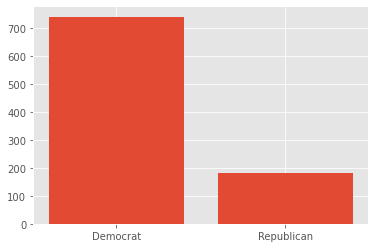

In [49]:
#people who said yes to the question: are you a feminist?
plot_feature(ready,'q109244')

Democrats: 38.95304080061586
Republicans: 61.04695919938414


Republican    793
Democrat      506
Name: party, dtype: int64

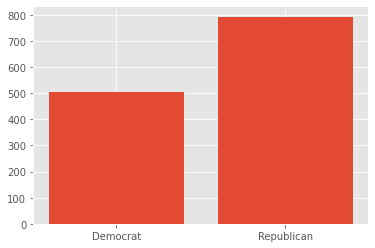

In [51]:
#people who said yes to the question: do you own a gun?
plot_feature(ready,'q115611')

Democrats: 48.51127819548872
Republicans: 51.48872180451127


Republican    1712
Democrat      1613
Name: party, dtype: int64

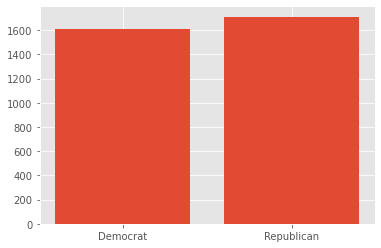

In [53]:
#Gender == Male
plot_feature(ready,'gender_Male')

Democrats: 59.6522514489523
Republicans: 40.3477485510477


Democrat      1338
Republican     905
Name: party, dtype: int64

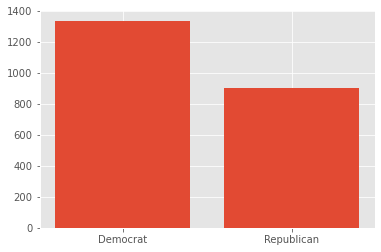

In [54]:
#Gender == Female
plot_feature(ready,'gender_Male',answer=0)

Democrats: 42.03691045796309
Republicans: 57.963089542036904


Republican    848
Democrat      615
Name: party, dtype: int64

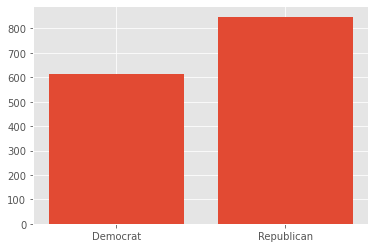

In [55]:
#people who said yes to the question: do you pray regularly?
plot_feature(ready,'q113181')

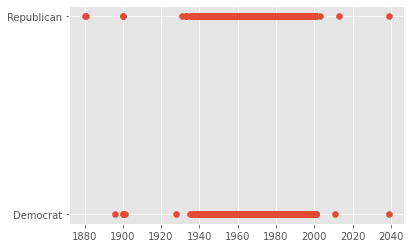

In [57]:
#scatter plot for yob versus the party you will vote for
plt.scatter(ready.yob,ready.party)

Democrats: 55.121349238996295
Republicans: 44.878650761003705


Democrat      1340
Republican    1091
Name: party, dtype: int64

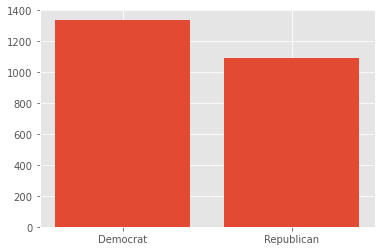

In [58]:
plot_feature(ready,'householdstatus_Single (no kids)')

Ok so 5 findings from the feature importance list are confirmed: 
1. people who identified as a feminist are highly likely to vote democrat (80%)
1. people who own a gun are high likely to vote republican (61%)
1. females are more likely to vote democrat (59%)
1. people who pray more often are more likley to vote republican (57%)
1. Single people with no kids are more likely to vote democrat (55%)

I still don't see a big correlation between year of birth and voting habits. Let's see if we can get any better results by combining our top two features (not including yob). 

In [59]:
#feminist and doesn't own a gun
ready[(ready.q109244 == 1) & (ready.q115611 == 0)].party.value_counts()

Democrat      502
Republican    112
Name: party, dtype: int64

In [60]:
#feminist and owns a gun
ready[(ready.q109244 == 1) & (ready.q115611 == 1)].party.value_counts()

Democrat      109
Republican     36
Name: party, dtype: int64

In [61]:
#not a feminist and don't own a gun
ready[(ready.q109244 == 0) & (ready.q115611 == 0)].party.value_counts()

Republican    614
Democrat      579
Name: party, dtype: int64

In [62]:
#not a feminist but owns a gun
ready[(ready.q109244 == 0) & (ready.q115611 == 1)].party.value_counts()

Republican    594
Democrat      292
Name: party, dtype: int64

So it looks like if you group together yes-feminist and no-gun we get a group where 81% of people vote democrat and if we group together no-feminist and yes-gun we get a group where 67% of people vote republican. These are increased percentages so maybe adding this feature will help? Only one way to find out. Let's test it

In [63]:
#adding a column for this new feature
ready['fem+gun'] = np.nan

In [64]:
ready.reset_index(inplace=True,drop=True)

In [67]:
#change fem+gun values to 1 where person is both a feminist and doesnt own a gun
indexes = np.where((ready['q109244'] == 1) & (ready['q115611'] == 0))[0]
for idx in indexes:
    ready.at[idx,'fem+gun'] = 1

In [68]:
#change fem+gun values to 0 where person is not a feminist and owns a gun
indexes = np.where((ready['q109244'] == 0) & (ready['q115611'] == 1))[0]
for idx in indexes:
    ready.at[idx,'fem+gun'] = 0

In [69]:
ready['fem+gun'].value_counts()

0.0    886
1.0    614
Name: fem+gun, dtype: int64

In [196]:
#doing another train_test_split with the new df. Also doing the same imputing again
X_tr, X_te, Y_tr, Y_te = train_test_split(ready.drop(['party','q109244','q115611'],axis=1), ready.party, stratify=ready.party,test_size=0.2, random_state=42)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp = imp.fit(X_tr)
xtrain_imp = imp.transform(X_tr)
xtest_imp = imp.transform(X_te)

In [247]:
#running the new RF model:
rf3 = RandomForestClassifier(n_estimators=100)
enhanced_confusion_matrix(rf3,xtrain_imp, xtest_imp, Y_tr, Y_te)

Precision: 60%
Recall: 65%
Train Accuracy: 99.95509654243376%
Test Accuracy: 59.06642728904848%
Mean CV Score: 59.429858507368124%
AUC Score: 61.82219562685988%
Log Loss: 0.674871480832578


array([[387, 203],
       [253, 271]])

In [198]:
feature_imp_list = list(zip(rf2.feature_importances_,X_tr.columns))
feature_imp_list.sort(reverse=True)
feature_imp_list

[(0.05861865944940882, 'yob'),
 (0.03571927039530591, 'q108617'),
 (0.014315692179043675, 'q115899'),
 (0.012682999447134595, 'gender_Male'),
 (0.012046026547919107, 'q112478'),
 (0.011259410707723986, 'fem+gun'),
 (0.01085811736419963, 'q120012'),
 (0.010774319580885223, 'q119334'),
 (0.01034292891136539, 'q121011'),
 (0.01006564958416191, 'householdstatus_Single (no kids)'),
 (0.010056437546410104, 'q120379'),
 (0.009825595180552139, 'q120978'),
 (0.009680477525948184, 'q119851'),
 (0.00965620075589417, 'q118237'),
 (0.009570479979775982, "educationlevel_Bachelor's Degree"),
 (0.009542669388524074, 'householdstatus_Married (w/kids)'),
 (0.009511449186662588, 'q118892'),
 (0.009486356556676593, 'q118117'),
 (0.009453547083966996, 'q120014'),
 (0.009437750884221989, 'q114748'),
 (0.00912558710083841, 'q115195'),
 (0.00909775275710261, 'q120472'),
 (0.00886915841890175, 'q115390'),
 (0.008855246494257653, 'q109367'),
 (0.008702127042012784, 'q120194'),
 (0.008694982641565758, 'q102674')

**Well combining two features into seemed to decrease all metrics except recall. So it is not helpful. It did drop the overfitting slightly though. It also brought out a few more potentially important features:** 
1. People who live in a single parent household
1. People who said the hardships in their lives are caused by their circumstances rather than themselves
1. People who have phobias

Democrats: 56.76959619952494
Republicans: 43.23040380047506


Democrat      239
Republican    182
Name: party, dtype: int64

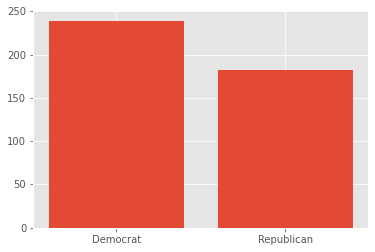

In [199]:
#people who live in a single parent household
plot_feature(ready,'q108617')

Democrats: 56.68918918918919
Republicans: 43.310810810810814


Democrat      839
Republican    641
Name: party, dtype: int64

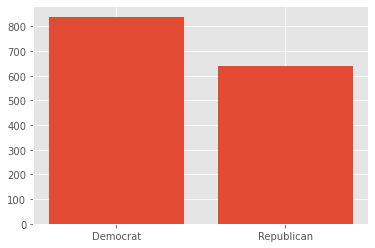

In [205]:
#people who said they think the hardships in their life are more due to circumstances than them
plot_feature(ready,'q115899',answer=1)

Democrats: 54.19354838709678
Republicans: 45.806451612903224


Democrat      1092
Republican     923
Name: party, dtype: int64

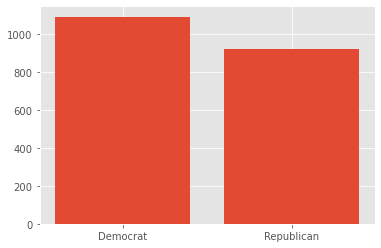

In [206]:
#people who said they have phobias
plot_feature(ready,'q112478',answer=1)

In [ ]:
#ready.to_pickle('ready.pkl')

In [268]:
#with open('random_forest.pkl', 'wb') as f:
    #pickle.dump(rf_fitted, f)

In [269]:
#with open('log_regres_fitted.pkl', 'wb') as f:
    #pickle.dump(lr_fitted, f)

In [270]:
#with open('naive_bayes_fitted.pkl', 'wb') as f:
    #pickle.dump(nbb_fitted, f)

In [271]:
#with open('ensemble_fitted.pkl', 'wb') as f:
    #pickle.dump(ensemble_fitted, f)